# Case Study: Credit Risk Prediction

This notebook builds a predictive classification model to identify credit card default payments based on customer attributes.

## Overview
### Objective:
Our goal is to:
- Preprocess the credit risk data using encoding methods.
- Train and tune predictive models using cross-validations with multiple algorithms
- Compare the models based on metrics including accuracy, precision, recall, F1-score
- Identify the best performing model based on these criteria and evaluate it on the test set
- Compute the optimal classification threshold for the selected model

### Dataset:
The dataset includes one target variable and 23 predictor variables:

- Target Variable (Y): Indicates whether the customer defaulted on a credit card payment (Yes = 1, No = 0).

- Predictor Variables (X1 to X23):
  - X1: Credit amount (NT dollar).
  - X2: Gender (1 = male; 2 = female).
  - X3: Education level (1 = graduate school; 2 = university; 3 = high school; 4 = others).
  - X4: Marital status (1 = married; 2 = single; 3 = others).
  - X5: Age (years).
  - X6 - X11: Historical monthly repayment statuses (-1 = paid duly, 1-9 = months delayed).
  - X12 - X17: Monthly bill statement amounts (NT dollar).
  - X18 - X23: Amount paid each month (NT dollar).

### Tasks
1. Load and preprocess the training and test datasets, clearly applying appropriate encodings
2. Train and tune models using cross-validation for each algorithm, illustrating hyperparameter tuning clearly with plots.
3. Select and justify the best-performing model.
4. Evaluate the selected best model on the test set using suitable classification metrics.
5. Compute the optimal probability threshold for classifying defaults, improving the performance evaluation.


## Setup and Data Loading


In [ ]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
)
from sklearn.svm import LinearSVC

# Model selection
from sklearn.model_selection import (
    GridSearchCV, RandomizedSearchCV, TunedThresholdClassifierCV
)

# Metrics
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
)

# For reproducibility: random states of all estimators
# are automatically set to this value
np.random.seed(42)

In [2]:
# Console markdown variables
UNDERLINE = "\033[04m"
BOLD = "\033[01m"
GREEN = "\033[92m"
BLUE = "\033[34m"
RESET = "\033[0m"

In [3]:
# Load train and test data
train_df = pd.read_csv("creditdefault_train.csv")
test_df = pd.read_csv("creditdefault_test.csv")

print(train_df.head())

   Y      X1  X2  X3  X4  X5  X6  X7  X8  X9  ...     X14     X15     X16  \
0  1   20000   2   2   1  24   2   2  -1  -1  ...     689       0       0   
1  0   50000   2   2   1  37   0   0   0   0  ...   49291   28314   28959   
2  0   50000   1   2   1  57  -1   0  -1   0  ...   35835   20940   19146   
3  0   50000   1   1   2  37   0   0   0   0  ...   57608   19394   19619   
4  0  500000   1   1   2  29   0   0   0   0  ...  445007  542653  483003   

      X17    X18    X19    X20    X21    X22    X23  
0       0      0    689      0      0      0      0  
1   29547   2000   2019   1200   1100   1069   1000  
2   19131   2000  36681  10000   9000    689    679  
3   20024   2500   1815    657   1000   1000    800  
4  473944  55000  40000  38000  20239  13750  13770  

[5 rows x 24 columns]


In [4]:
# Separate features from labels
X_train = train_df.drop("Y", axis=1)
y_train = train_df["Y"]

X_test = test_df.drop("Y", axis=1)
y_test = test_df["Y"]

In [5]:
X_train.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000
mean,167450.245333,1.604867,1.850000,1.556200,35.367933,-0.020467,-0.130933,-0.163000,-0.214467,-0.256933,...,47117.562067,43077.445667,40272.922667,38708.685867,5615.960000,5.822059e+03,4942.959000,4997.328867,4798.478400,5226.421267
std,130109.925023,0.488896,0.786686,0.522743,9.154118,1.125048,1.198451,1.202606,1.180578,1.148654,...,69182.434940,64016.907786,60503.339354,59212.425410,15551.708028,2.155675e+04,13629.034736,16499.349511,15463.948485,18099.851948
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-34041.000000,-170000.000000,-46627.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2733.500000,2392.750000,1800.000000,1200.000000,1000.000000,8.330000e+02,390.000000,290.000000,204.000000,80.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,20165.000000,19090.500000,18178.000000,17177.000000,2113.000000,2.014000e+03,1809.000000,1500.000000,1500.000000,1500.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,60263.250000,54599.500000,50134.750000,49122.750000,5023.250000,5.000000e+03,4571.500000,4048.500000,4019.500000,4000.000000
max,800000.000000,2.000000,6.000000,3.000000,75.000000,8.000000,8.000000,8.000000,8.000000,7.000000,...,855086.000000,706864.000000,587067.000000,568638.000000,493358.000000,1.227082e+06,380478.000000,528897.000000,426529.000000,528666.000000


In [6]:
# Check for missing values
print(X_train.loc[X_train.isnull().any(axis=1)])
print(X_test.loc[X_test.isnull().any(axis=1)])

Empty DataFrame
Columns: [X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17, X18, X19, X20, X21, X22, X23]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17, X18, X19, X20, X21, X22, X23]
Index: []

[0 rows x 23 columns]


## Exploratory Data Analysis

We begin our analysis with an exploration of the data structure and target variable to understand the distribution of classes and the behaviour of features.

### Class Imbalance
One of the key challenges observed in the dataset is the **imbalance seen in the label `Y`**, which represents whether a credit card holder defaulted on their payment (1 = default, 0 = no default).

The plot below shows that:
- Approximately **77.8%** of the training samples belong to class **0** (no default).
- Only **22.2%** of samples represent the positive class **1** (default).

This imbalance poses a risk of developing biased models that favour predicting the majority class. For instance, a model that always predicts “no default” would achieve nearly 78% accuracy but would completely fail to identify defaulters, which are the most important cases for a credit risk model.

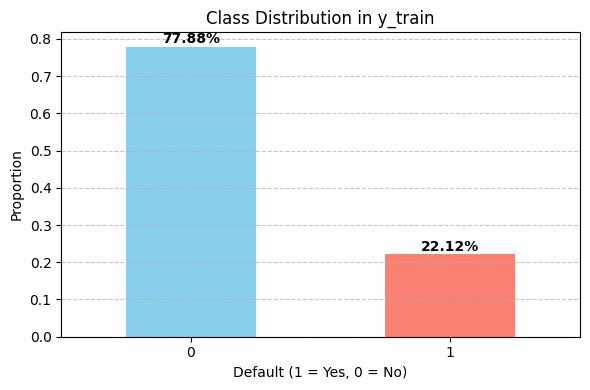

In [7]:
import matplotlib.pyplot as plt

# Get class distribution (normalized)
class_dist = y_train.value_counts(normalize=True)

# Plot
plt.figure(figsize=(6,4))
class_dist.plot(kind='bar', color=['skyblue', 'salmon'])

# Labeling
plt.title('Class Distribution in y_train')
plt.xlabel('Default (1 = Yes, 0 = No)')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show percentage on top of bars
for i, v in enumerate(class_dist):
    plt.text(i, v + 0.01, f"{v:.2%}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


### Distribution of Numeric Features
To understand the spread and range of the input features, we plotted histograms of all the variables.

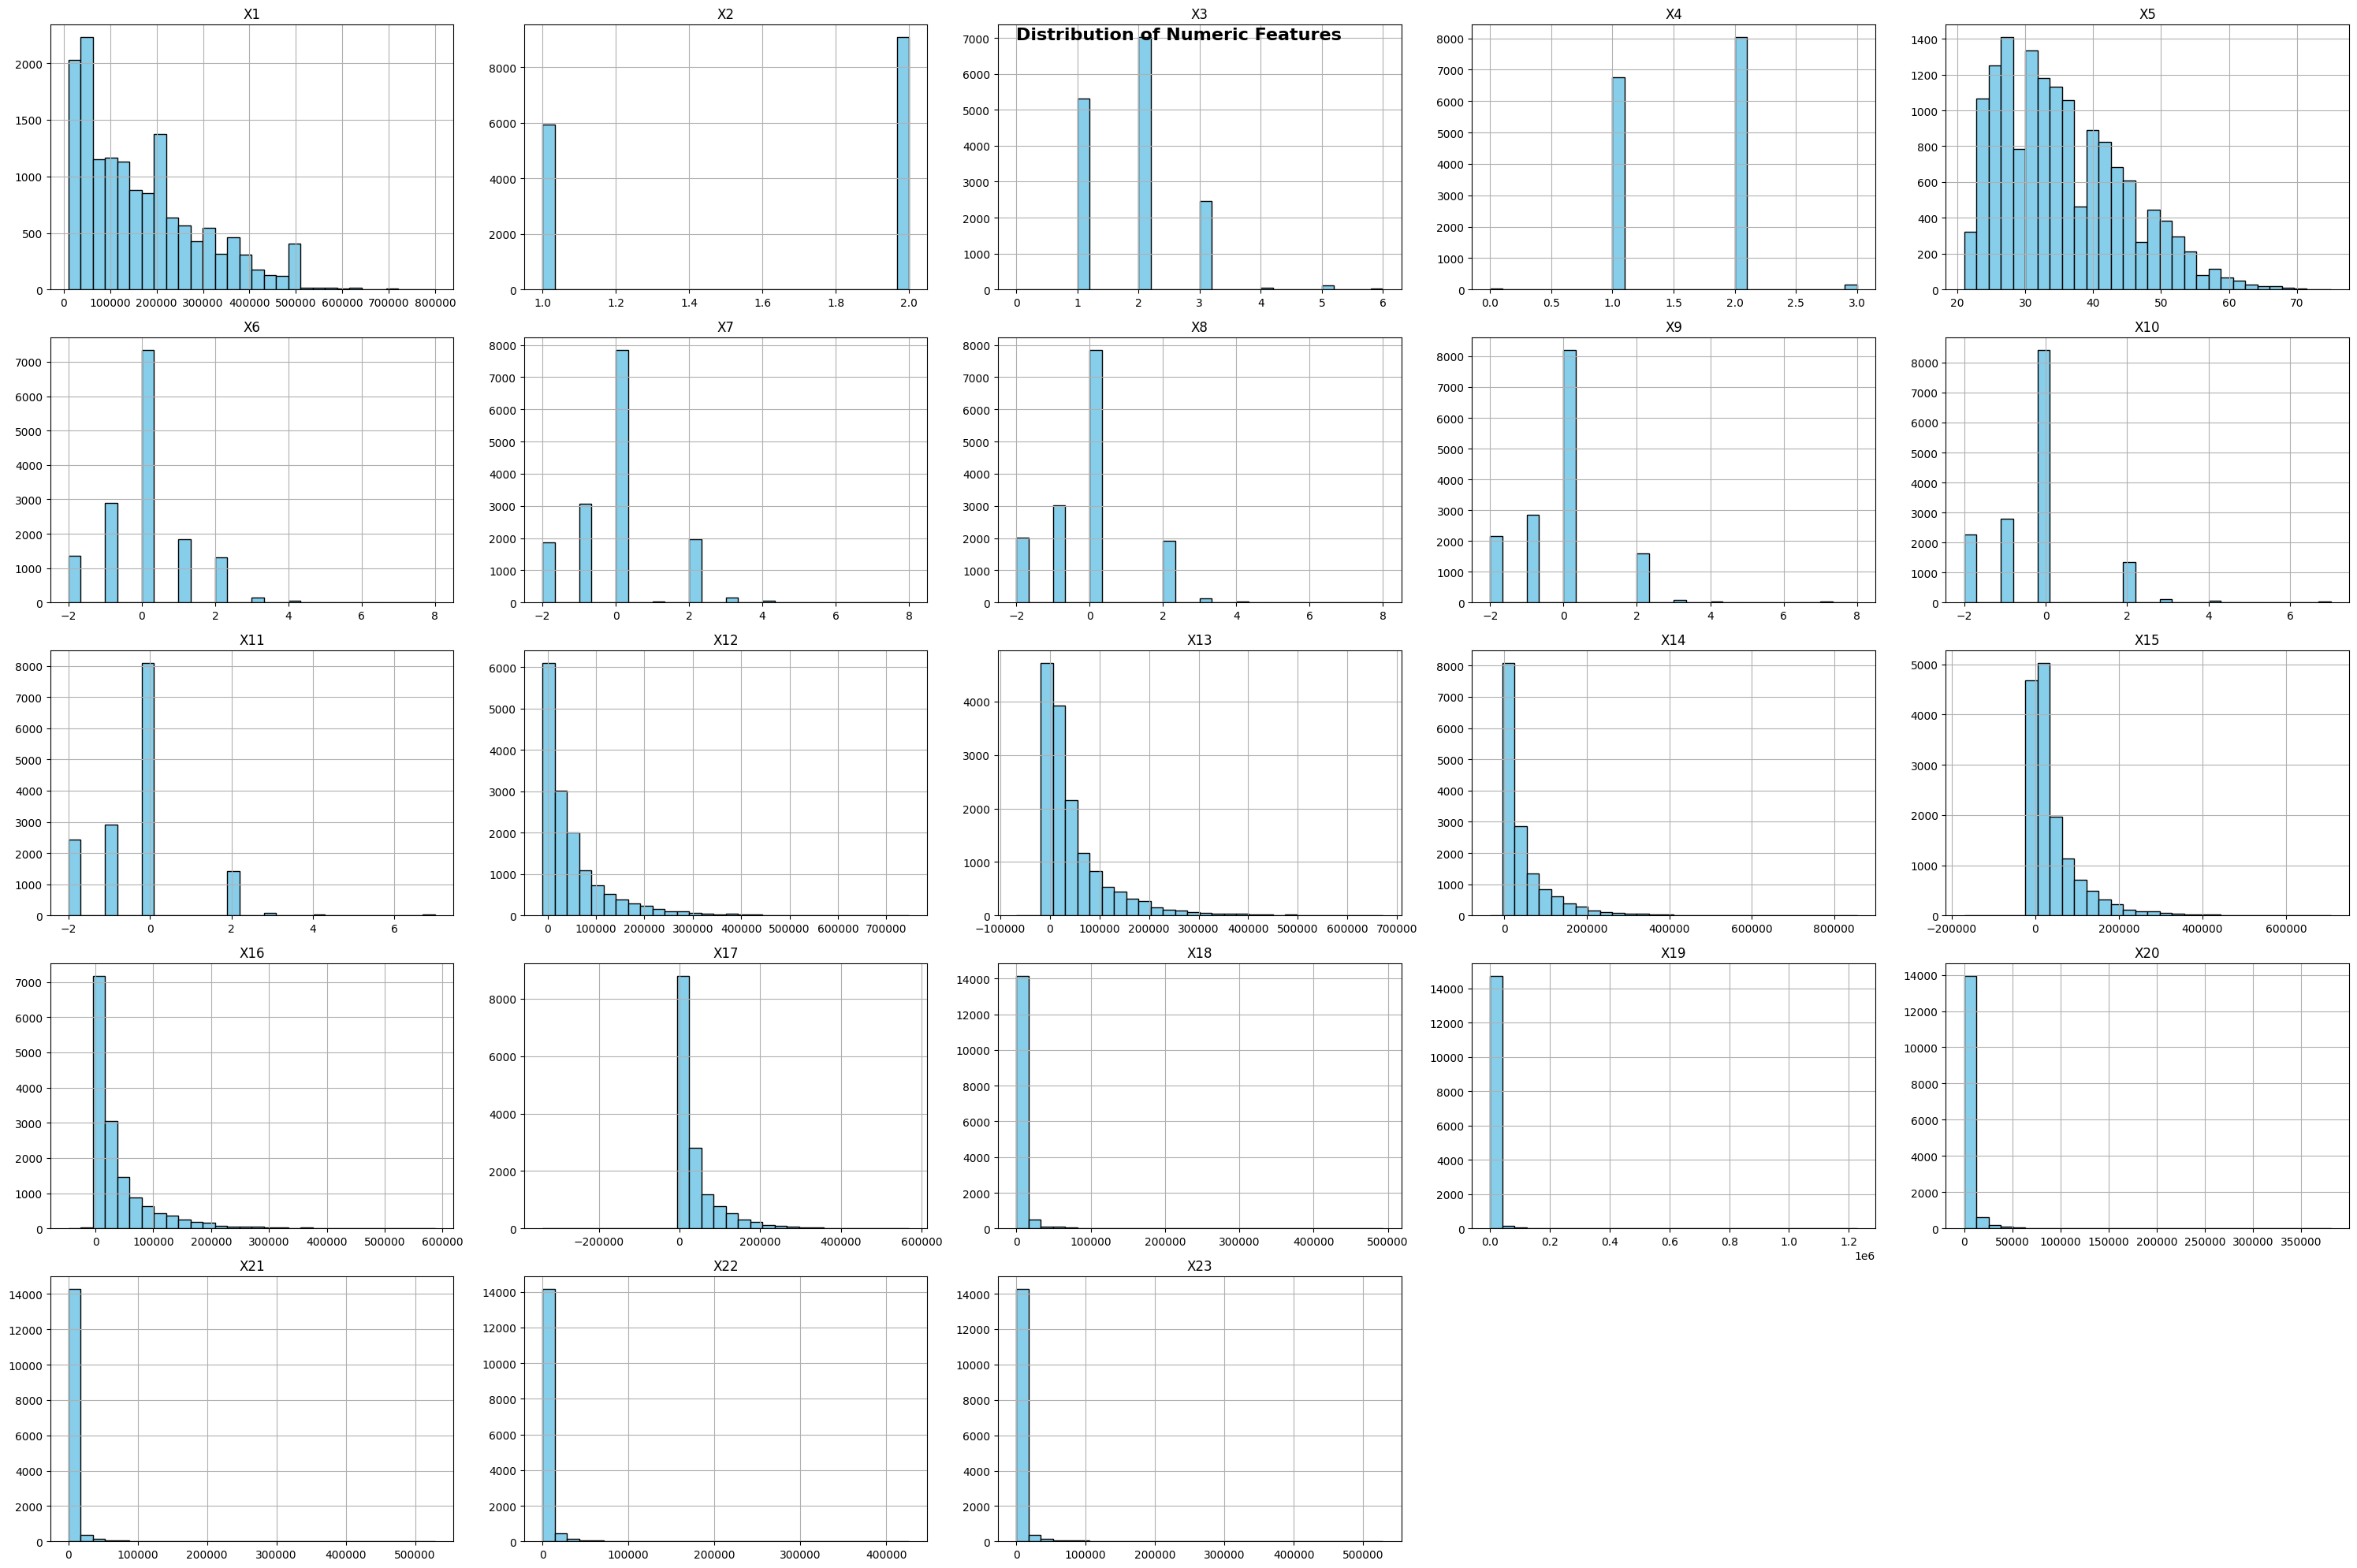

In [ ]:
# Plot all numeric features
numeric_features = train_df.drop(columns=["Y"]).select_dtypes(include=[np.number]).columns

train_df[numeric_features].hist(bins=30, figsize=(30, 20), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.suptitle('Distribution of Numeric Features', fontsize=16, fontweight='bold')
plt.show()

## Methods of Combatting Class Imbalance

To address the imbalance in the target variable (default vs. non-default), several techniques can be employed. These aim to either balance the data distribution, adjust model learning, or improve evaluation beyond simple accuracy.

### 1. Class Weight Adjustments

Most sklearn estimators feature a `class_weight` parameter.  
Setting `class_weight="balanced"` tells the model to give more weight to the minority class (defaults) during training.  

This helps the model learn patterns related to defaulters, which are otherwise underrepresented.

### 2. Binary Classification Metrics

Rather than soley relying on accuracy, a better approach to evaluate binary classification performance on an unbalanced dataset is to use metrics such as:

- **Precision**: The rate of true positive predictions out of all positive predictions made. `TP / (TP + FP)`

- **Recall**: The rate of true positive predictions out of all actual positives. `TP / (TP + FN)`

- **F1 Score**: The harmonic mean of the precision and recall rates. `2 / (1/precision + 1/recall)`

### 3. Cost Matrix

A cost matrix (such as below) could be implemented to contextualise the importance of detecting true positives by assigning costs to predictions. 

| | Predicted Default | Predicted Non-default |
| :-: | :-: | :-: |
| **Actual Default** | +0 | -100 |
| **Actual Non-default** | -50 | +100 |

We decided against this, however, as it forced us to make too many assumptions about the application of model.

### 4. Resampling Methods

#### **Oversampling**: Artifically increase the number of minority class (defaulter) instances.

- Can be done via random oversampling or SMOTE (Synthetic Minority Over-sampling Technique), which generates new synthetic examples.

#### **Undersampling**: Reduce the number of majority class (non-defaulter) instances.

- Addresses the imbalance issue but may result in loss of important patterns, meaning the model is less able to adapt to the training data.

### Chosen Methods

- Ultimately, we chose to implement the estimators' `class_weight="balanced"` parameter which weighted the two classes proportionally to their representation in the dataset (e.g. minority class of 20% would be weighted 4x the majority class).

- We also use F1 as the metric of choice to compare overall model performances, as it gives proportional importances to both precision and recall.

## Preprocessing Pipeline

The nominal features `gender (X2)` and `marital status (X4)` should be one-hot encoded using sklearn's `OneHotEncoder` class, as they have no natural order.

Ordinal features such as `education level (X3)` and `historical monthly repayment statuses (X6-X11)` are already ordinally encoded in this dataset, and so will be passed through with no transformation.

Numerical features will be standardised using sklearn's `StandardScaler` class, to prevent features with larger ranges from disproportionately affecting predictions.

In [10]:
def preprocess_data(X: pd.DataFrame) -> np.ndarray:
    nom_cols = ["X2", "X4"] # X2 = gender, X4 = marital status
    ord_cols = ["X3", "X6", "X7", "X8", "X9", "X10", "X11"]

    nominal_features = list(X[nom_cols].copy())
    ordinal_features = list(X[ord_cols].copy())
    numerical_features = list(X.drop(ord_cols + nom_cols, axis=1))

    full_pipeline = ColumnTransformer([
        ("nom", OneHotEncoder(), nominal_features),     # One-hot encode nominal features
        ("ord", "passthrough", ordinal_features),       # Ordinal features already encoded
        ("num", StandardScaler(), numerical_features),  # Standardise numerical features
    ])

    return full_pipeline.fit_transform(X)

In [11]:
prepared_X_train = preprocess_data(X_train)

prepared_X_train.shape

(15000, 27)

## Helper Functions

### Model Tuning

#### model_trainer

A custom function that automates the hyperparameter tuning of an estimator, returning the best estimator and cross validation results.

In [48]:
def model_trainer(
    model, 
    X: np.ndarray,
    y: pd.Series,
    param_grid: dict[str, list],
    validation_folds: int = 5,
    verbose: bool = True,
    random: bool = False
) -> tuple:
    """
    Perform a grid/random search fitted to the given features and labels
    on an estimator, returning a tuple containing the best found estimator
    and the search results.
    """
    print(f"{BLUE}Search Parameters:{RESET}")
    for k, v in param_grid.items():
        print(f"{k}: {v}")
    print(f"\n{BLUE}Validation Folds:{RESET}\n{validation_folds}")
    print(f"\n{UNDERLINE}{BLUE}Performing hyperparameter search...{RESET}")

    if random: # Perform a random search
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid,
            cv=validation_folds,
            n_iter=20,
            n_jobs=-1,
            scoring=["accuracy", "precision", "recall", "f1"],
            refit="f1",
            return_train_score=True,
            error_score="raise"
        ).fit(X, y)
    else: # Perform a grid search
        search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=validation_folds,
            n_jobs=-1,
            scoring=["accuracy", "precision", "recall", "f1"],
            refit="f1",
            return_train_score=True,
            error_score="raise"
        ).fit(X, y)

    cv_results = search.cv_results_

    # Print the results of the hyperparameter search
    if verbose:
        for i, (mean_f1, mean_pre, mean_rec, mean_acc, params) in enumerate(zip(
            cv_results["mean_test_f1"], cv_results["mean_test_precision"],
            cv_results["mean_test_recall"], cv_results["mean_test_accuracy"],
            cv_results["params"])):
            print(f"\n{BOLD}{BLUE}{i+1}:{RESET} {params}")
            print(f"    Mean F1 Score: {GREEN}{round(mean_f1, 3)}{RESET}")
            print(f"    Mean Precision: {GREEN}{round(mean_pre, 3)}{RESET}")
            print(f"    Mean Recall: {GREEN}{round(mean_rec, 3)}{RESET}")
            print(f"    Mean Accuracy: {GREEN}{round(mean_acc, 3)}{RESET}")

    # Print the best estimator's result
    print(f"\n{UNDERLINE}{BLUE}BEST RESULT:{RESET}\n")
    print(f"{BOLD}{BLUE}{search.best_index_+1}:{RESET} {search.best_params_}")
    print(f"    Mean F1 Score: {GREEN}{round(search.best_score_, 3)}{RESET}\n")

    return search.best_estimator_, cv_results

#### model_threshold_tuner

A function to be used as a final tuning step to find the optimal model to use on the test set. It automatically tunes the decision threshold of an estimator to optimise the F1 score.

In [13]:
def model_threshold_tuner(
    model,
    X: np.ndarray,
    y: pd.Series,
    validation_folds: int = 5,
) -> tuple:
    """
    Perform an automatic search on a given estimator for the
    best decision threshold to optimise F1.
    """
    tuned_threshold = TunedThresholdClassifierCV(
        estimator=model,
        cv=validation_folds, 
        n_jobs=-1,
        scoring="f1",
        store_cv_results=True,
    ).fit(X, y)
    
    cv_results = tuned_threshold.cv_results_

    print(f"Best threshold: {tuned_threshold.best_threshold_:.3f}")
    print(f"Best F1 score: {tuned_threshold.best_score_:.3f}")

    return tuned_threshold.estimator_, cv_results

### Plotting

We created helper functions that visualises how well a model performs. These plots help us compare training and test results, see how models behave at different thresholds, and understand calssification errors.

#### plot_accuracy_vs_hyperparameter

Plots training and test accuracies against one hyperparameter changed in isolation, to measure how it can affect model performance individually.

In [58]:
def plot_accuracy_vs_hyperparameter(
    cv_results: dict[str, np.ndarray], 
    param_name: str,
    log: bool = False
) -> None:
    """
    Display the change in training and test accuracies for an estimator
    as one selected hyperparameter is varied.
    """
    test_acc = "mean_test_accuracy"
    train_acc = "mean_train_accuracy"

    # Convert cv_results into a DataFrame for easier manipulation.
    df = pd.DataFrame(cv_results)
    
    # Build the column name (e.g., 'max_features' becomes 'param_max_features').
    col_name = f"param_{param_name}"
    
    # Extract the relevant columns.
    data = df[[col_name, test_acc, train_acc]].copy()
    
    # Check if the hyperparameter values are numeric.
    if pd.api.types.is_numeric_dtype(data[col_name]):
        # Group by the numeric hyperparameter and sort by the index.
        grouped_test = data.groupby(col_name)[test_acc].mean().sort_index()
        grouped_train = data.groupby(col_name)[train_acc].mean().sort_index()
        x_values = grouped_test.index
    else:
        # If values are non-numeric, convert them to strings and group without sorting.
        grouped_test = data.groupby(col_name)[test_acc].mean()
        grouped_train = data.groupby(col_name)[train_acc].mean()
        x_values = grouped_test.index.astype(str)
    
    # Extract y-values for both metrics.
    y_test_values = grouped_test.values
    y_train_values = grouped_train.values

    # Create the plot.
    plt.figure(figsize=(8, 5))
    if log:
        plt.xscale("log")
    plt.plot(x_values, y_test_values, label='Test Accuracy', linestyle='-', color='blue')
    plt.plot(x_values, y_train_values, label='Train Accuracy', linestyle='-', color='orange')
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
    plt.title(f'Test and Train Accuracy vs. {param_name}')
    plt.legend()
    plt.show()

#### plot_roc_curve

Displays the ROC curve for a model on a test set to inform the selection of a decision threshold.

In [15]:
def plot_roc_curve(
    model, 
    X: np.ndarray,
    y: pd.Series,
    model_name: str = "Model"
) -> None:
    """Plot the ROC curve for a given model and test data."""
    # Get predicted probabilities for the positive class
    y_scores = model.predict_proba(X)[:, 1]

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

#### plot_confusion_matrix

Displays a model's confusion matrix graphically.

In [137]:
def plot_confusion_matrix(
    model,
    X: np.ndarray,
    y: pd.Series,
    model_name: str = "Model",
    threshold: float | None = None
) -> None:
    """Plot the confusion matrix for a model and test data."""
    # Get predicted probabilities for the positive class
    y_scores = model.predict_proba(X)[:, 1]

    # Apply threshold if provided
    if threshold is not None:
        y_pred = (y_scores >= threshold).astype(int)
    else:
        y_pred = model.predict(X)

    # Compute confusion matrix
    cm = confusion_matrix(y, y_pred)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

## Model Training

We trained and fine-tuned six classifiers using our custom functions `model_tuner` and `model_threshold_tuner` with 5-fold cross-validation to predict credit card defaults. 

### 1. K-Nearest Neighbour Classifier

The ***k-Nearest Neighbour (k-NN)*** algorithm predicts a class by looking at how the closest training points (neighbours) are labelled. It does not train a model in advance but instead makes predictions based on stored data.

#### Hyperparameters Tuned

1. `n_neighbors`

    Controls how many nearby data points the model considers when making a prediction:
    
    - A small number might be too sensitive to noise.
    
    - A large number may cause the model to miss patterns in the data.

2. `p`

    The power to use when calculating Minkowski distance:

    - `p=1`: Manhattan distance.

    - `p=2`: Euclidean distance (the default choice).

    - Higher `p` values give more weight to larger differences in features.

3. `weights`

    How much each neighbour contributes to the prediction:

    - `'uniform'`: Every neighbour counts the same.

    - `'distance'`: Neighbours that are closer to the data point have more influence.

#### Initial Grid Search

In [138]:
k_neighbours = KNeighborsClassifier()

k_neighbours_param_grid = {
    "n_neighbors": [1,2,3,4,5,6],           # Number of nearest neighbours to consider
    "p": [1,2,3,4,5],                       # Power to use for Minkowski distance
    "weights": ["uniform", "distance"],     # Weight function to use
}

k_neighbours, results = model_trainer(
    k_neighbours, 
    prepared_X_train, 
    y_train,
    k_neighbours_param_grid,
)

k_neighbours

Search Parameters:
n_neighbors: [1, 2, 3, 4, 5, 6]
p: [1, 2, 3, 4, 5]
weights: ['uniform', 'distance']

Validation Folds:
5

Performing hyperparameter search...

1: {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
    Mean F1 Score: 0.384
    Mean Precision: 0.383
    Mean Recall: 0.387
    Mean Accuracy: 0.726

2: {'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
    Mean F1 Score: 0.384
    Mean Precision: 0.383
    Mean Recall: 0.387
    Mean Accuracy: 0.726

3: {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
    Mean F1 Score: 0.38
    Mean Precision: 0.382
    Mean Recall: 0.379
    Mean Accuracy: 0.727

4: {'n_neighbors': 1, 'p': 2, 'weights': 'distance'}
    Mean F1 Score: 0.38
    Mean Precision: 0.382
    Mean Recall: 0.379
    Mean Accuracy: 0.727

5: {'n_neighbors': 1, 'p': 3, 'weights': 'uniform'}
    Mean F1 Score: 0.378
    Mean Precision: 0.381
    Mean Recall: 0.374
    Mean Accuracy: 0.727

6: {'n_neighbors': 1, 'p': 3, 'weights': 'distance'}
    Mean F1 Score: 0.378


KNeighborsClassifier(n_neighbors=6, p=5, weights='distance')

##### Best Model Setup:

``` python
{'n_neighbors': 6, 'p': 5, 'weights': 'distance'}
    Mean F1 Score: 0.432
    Mean Precision: 0.56
    Mean Recall: 0.353
    Mean Accuracy: 0.795
```

This setup used the highest number of neighbours available, `n_neighbors=6`. This told us the model performed better when it considered more data points. 

Using the highest power `p=5` also contributed to achieving the best results.

#### Refined Grid Search

The initial grid search suggested that model performance may continue to improve if `n_neighbors` or `p` were further increased. 

To test this hypothesis, we ran a second search focused on these hyperparameters in particular.

In [ ]:
k_neighbours_param_grid = {
    "n_neighbors": [6,7,8,9,10],
    "p": [4,5,6],
    "weights": ["distance"],
}

k_neighbours, results = model_trainer(
    k_neighbours, 
    prepared_X_train, 
    y_train, 
    k_neighbours_param_grid,
)

k_neighbours

##### Best Model Setup:

``` python
{'n_neighbors': 9, 'p': 6, 'weights': 'distance'}
    F1 Score: 0.444
    Precision: 0.611
    Recall: 0.350
    Accuracy: 0.806
```

The results of this search showed slight gains in all metrics (e.g. F1 score of `0.432` → `0.444`) over the first round, suggesting the model became more stable. 

Increasing `n_neighbours` to `9` appeared to make it less sensitive to small variations in the data.

#### Accuracy vs. n_neighbours

Search Parameters:
n_neighbors: range(1, 21)
p: [6]
weights: ['distance']

Validation Folds:
5

Performing grid search...

1: {'n_neighbors': 1, 'p': 6, 'weights': 'distance'}
    Mean F1 Score: 0.384
    Mean Precision: 0.39
    Mean Recall: 0.379
    Mean Accuracy: 0.732

2: {'n_neighbors': 2, 'p': 6, 'weights': 'distance'}
    Mean F1 Score: 0.384
    Mean Precision: 0.391
    Mean Recall: 0.379
    Mean Accuracy: 0.732

3: {'n_neighbors': 3, 'p': 6, 'weights': 'distance'}
    Mean F1 Score: 0.411
    Mean Precision: 0.483
    Mean Recall: 0.36
    Mean Accuracy: 0.773

4: {'n_neighbors': 4, 'p': 6, 'weights': 'distance'}
    Mean F1 Score: 0.412
    Mean Precision: 0.487
    Mean Recall: 0.358
    Mean Accuracy: 0.775

5: {'n_neighbors': 5, 'p': 6, 'weights': 'distance'}
    Mean F1 Score: 0.426
    Mean Precision: 0.542
    Mean Recall: 0.352
    Mean Accuracy: 0.791

6: {'n_neighbors': 6, 'p': 6, 'weights': 'distance'}
    Mean F1 Score: 0.429
    Mean Precision: 0.558
    Mean R

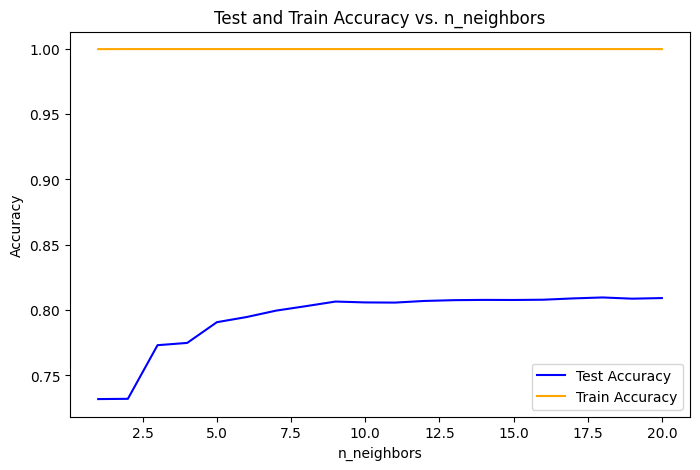

In [23]:
k_neighbours_param_grid = {
    "n_neighbors": range(1, 21),
    "p": [6],
    "weights": ["distance"]
}

k_neighbours, results = model_trainer(
    k_neighbours, 
    prepared_X_train, 
    y_train, 
    k_neighbours_param_grid
)

plot_accuracy_vs_hyperparameter(results, param_name="n_neighbors")

The training accuracy holding a constant value of **1.00** is not surprising given that the k-NN algorithm essentially works by memorising the entire training set.

Test accuracy shows significant gains in accuracy up to **~9** neighbours before quickly plateauing, not seeing any further increase with number of neighbours.

#### Decision Threshold Tuning

In [139]:
best_k_neighbours = KNeighborsClassifier(
    n_neighbors=9, 
    p=6, 
    weights="distance"
)

best_k_neighbours, results = model_threshold_tuner(
    best_k_neighbours, 
    prepared_X_train, 
    y_train
)

Best threshold: 0.354
Best F1 score: 0.489


Reducing the decision threshold from the default **0.5** to **0.354** saw a significant improvement in F1 score from **0.444** → **0.489**.

#### Final Results

- F1 Score: 0.489

- Best Decision Threshold: 0.354

- AUC Score: N/A

As the KNeighborsClassifier perfectly fits to the training set, computing an ROC curve for the model would result in AUC score of 1.

This provides no insight as to how the model generalises to unseen data, and so is not considered.

### 2. Decision Tree Classifier

A Decision Tree makes predictions by splitting the data using simple rules called splitting criteria. 

At each split, it separates instances into nodes to locally minimise the impurity measure.

**Hyperparameters Tuned:**

1) `max_depth`

    Controls how many levels the tree can have. 
    - A deeper tree can learn more details but may overfit the training data. 
    - Limiting depth keeps the model general and reduces complexity.

2) `min_samples_split`

    Sets the minimum number of samples needed to split a group.
      - Lower values can lead to overfitting with very small branches.
      - A higher value keeps the tree simpler.

3) `min_samples_leaf`

    Sets the smallest number of samples allowed in a final group (leaf).
    - Helps prevent the model from learning too much from outliers or noise.
    - Larger values produce smoother, more stable trees.

#### Initial Grid Search

In [140]:
decision_tree = DecisionTreeClassifier(class_weight="balanced")

decision_tree_param_grid = {
    "max_depth": [3, 4, 5, 6],              # Pre-pruning, prevents tree from growing further
    "min_samples_leaf": [1, 3, 5, 7],       # Min. samples needed at a leaf node                  
    "min_samples_split": [2, 3, 4, 5],      # Min. samples at a node needed to split further
}

decision_tree, results = model_trainer(
    decision_tree,
    prepared_X_train,
    y_train,
    decision_tree_param_grid
)

decision_tree

Search Parameters:
max_depth: [3, 4, 5, 6]
min_samples_leaf: [1, 3, 5, 7]
min_samples_split: [2, 3, 4, 5]

Validation Folds:
5

Performing hyperparameter search...

1: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
    Mean F1 Score: 0.514
    Mean Precision: 0.47
    Mean Recall: 0.567
    Mean Accuracy: 0.763

2: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3}
    Mean F1 Score: 0.514
    Mean Precision: 0.47
    Mean Recall: 0.567
    Mean Accuracy: 0.763

3: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 4}
    Mean F1 Score: 0.514
    Mean Precision: 0.47
    Mean Recall: 0.567
    Mean Accuracy: 0.763

4: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}
    Mean F1 Score: 0.514
    Mean Precision: 0.47
    Mean Recall: 0.567
    Mean Accuracy: 0.763

5: {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}
    Mean F1 Score: 0.514
    Mean Precision: 0.47
    Mean Recall: 0.567
    Mean Accuracy: 0.763

6: {'

DecisionTreeClassifier(class_weight='balanced', max_depth=4, min_samples_leaf=7)

##### Best Model Setup:
```python
{'max_depth': 4, 'min_samples_leaf': 7, 'min_samples_split': 2}
    Mean F1 Score: 0.518
    Mean Precision: 0.502
    Mean Recall: 0.535
    Mean Accuracy: 0.78
```

#### Refined Grid Search
After identifying a strong base setup, we ran a second grid search focusing only on `min_samples_leaf`, while keeping the other values fixed.

In [141]:
decision_tree_param_grid = {
    "max_depth": [4],
    "min_samples_leaf": [7, 8, 9, 10, 11, 12, 13, 14],
    "min_samples_split": [2],
}

decision_tree, results = model_trainer(
    decision_tree,
    prepared_X_train,
    y_train,
    decision_tree_param_grid
)

decision_tree

Search Parameters:
max_depth: [4]
min_samples_leaf: [7, 8, 9, 10, 11, 12, 13, 14]
min_samples_split: [2]

Validation Folds:
5

Performing hyperparameter search...

1: {'max_depth': 4, 'min_samples_leaf': 7, 'min_samples_split': 2}
    Mean F1 Score: 0.518
    Mean Precision: 0.502
    Mean Recall: 0.535
    Mean Accuracy: 0.78

2: {'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 2}
    Mean F1 Score: 0.518
    Mean Precision: 0.502
    Mean Recall: 0.535
    Mean Accuracy: 0.78

3: {'max_depth': 4, 'min_samples_leaf': 9, 'min_samples_split': 2}
    Mean F1 Score: 0.518
    Mean Precision: 0.502
    Mean Recall: 0.535
    Mean Accuracy: 0.779

4: {'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 2}
    Mean F1 Score: 0.518
    Mean Precision: 0.502
    Mean Recall: 0.535
    Mean Accuracy: 0.78

5: {'max_depth': 4, 'min_samples_leaf': 11, 'min_samples_split': 2}
    Mean F1 Score: 0.519
    Mean Precision: 0.503
    Mean Recall: 0.537
    Mean Accuracy: 0.78

6: 

DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=11)

##### Best Model Setup:
```python
{'max_depth': 4, 'min_samples_leaf': 11, 'min_samples_split': 2}
    Mean F1 Score: 0.519    
    Mean Precision: 0.503
    Mean Recall: 0.537
    Mean Accuracy: 0.78
```
This showed that `min_samples_leaf=11` appeared to be the optimal value. Increasing this number further caused a negligible change in any performance.

#### Accuracy vs. max_depth

Search Parameters:
max_depth: range(1, 101)
min_samples_leaf: [11]
min_samples_split: [2]

Validation Folds:
5

Performing hyperparameter search...

1: {'max_depth': 1, 'min_samples_leaf': 11, 'min_samples_split': 2}
    Mean F1 Score: 0.509
    Mean Precision: 0.504
    Mean Recall: 0.515
    Mean Accuracy: 0.78

2: {'max_depth': 2, 'min_samples_leaf': 11, 'min_samples_split': 2}
    Mean F1 Score: 0.509
    Mean Precision: 0.504
    Mean Recall: 0.515
    Mean Accuracy: 0.78

3: {'max_depth': 3, 'min_samples_leaf': 11, 'min_samples_split': 2}
    Mean F1 Score: 0.515
    Mean Precision: 0.471
    Mean Recall: 0.568
    Mean Accuracy: 0.763

4: {'max_depth': 4, 'min_samples_leaf': 11, 'min_samples_split': 2}
    Mean F1 Score: 0.519
    Mean Precision: 0.503
    Mean Recall: 0.537
    Mean Accuracy: 0.78

5: {'max_depth': 5, 'min_samples_leaf': 11, 'min_samples_split': 2}
    Mean F1 Score: 0.51
    Mean Precision: 0.447
    Mean Recall: 0.606
    Mean Accuracy: 0.742

6: {'max_depth'

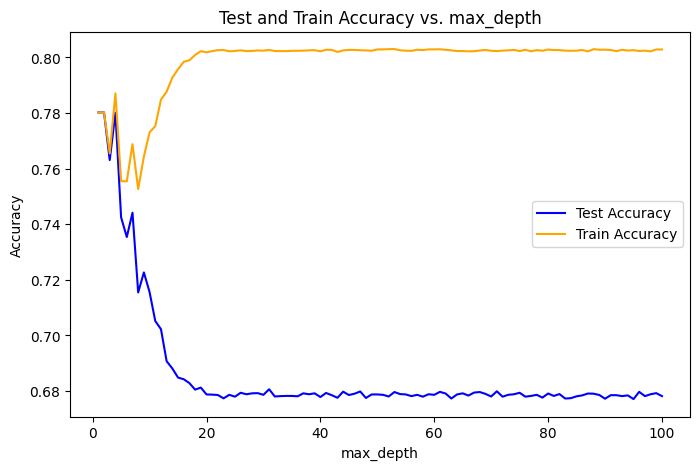

In [142]:
decision_tree_param_grid = {
    "max_depth": range(1, 101),
    "min_samples_leaf": [11],
    "min_samples_split": [2],
}

decision_tree, results = model_trainer(
    decision_tree,
    prepared_X_train,
    y_train,
    decision_tree_param_grid
)

plot_accuracy_vs_hyperparameter(results, param_name="max_depth")

The plot shows test accuracy peaks at a tree depth of **4**, then declines as the model overfits. Deeper trees perform well on training data but generalise poorly.

#### Decision Threshold Tuning

In [144]:
best_decision_tree = DecisionTreeClassifier(
    class_weight="balanced",
    max_depth=4, 
    min_samples_leaf=11, 
    min_samples_split=2
)

best_decision_tree, results = model_threshold_tuner(
    best_decision_tree, 
    prepared_X_train, 
    y_train
)

Best threshold: 0.605
Best F1 score: 0.520


The best threshold was found to be **0.605**, increasing the F1 score by a negligible amount (**0.519** → **0.520**).

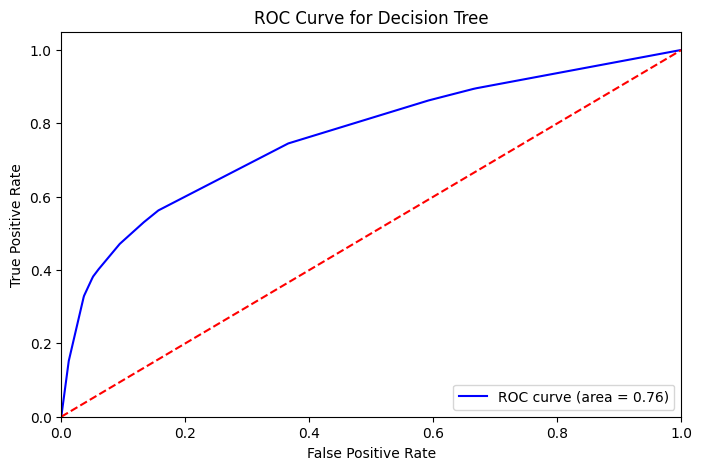

In [145]:
plot_roc_curve(
    model=best_decision_tree,
    X=prepared_X_train,
    y=y_train,
    model_name="Decision Tree",
)

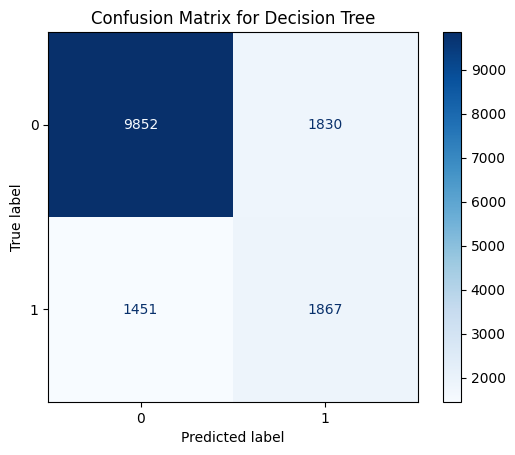

In [146]:
plot_confusion_matrix(
    model=best_decision_tree,
    X=prepared_X_train,
    y=y_train,
    model_name="Decision Tree"
)

#### Final Results

- F1 Score: 0.520

- Best Decision Threshold: 0.605

- AUC Score: 0.76

### 3. Random Forest Classifier

Random Forest is an ensemble learning method that builds multiple Decision Trees on different subsets of the data and features. 

It then takes the majority predictions from all trees to make a final decision. 

This approach reduces overfitting and improves accuracy compared to a single Decision Tree.

#### Hyperparameters Tuned

1) `n_estimators`  

    The number of trees in the forest:
        
    - A higher number generally improves performance but increases computational time.

2) `max_features`  

    The number of features to consider when looking for the best split, controlling how diverse the trees are:

    - `max_features=0.1`: Only consider 10% of all features per tree.

    - `max_features=None`: Consider all features for each tree.

3) `max_depth`  

    The maximum depth of each tree:
    
    - `max_depth=None`: No limit for growth, allowing the trees to overfit the training data.

4) `min_samples_leaf`  

    The minimum number of samples required to be at a leaf node. This keeps trees from being too specific and helps with generalisation.

#### Initial Grid Search

A large number of trees were used (`n_estimators=500`), and `max_depth` values of both the previously-found optimal value (**4**) and **None** (allowing the trees to overfit) were tested.

The trees' `min_samples_leaf` parameter was frozen at the best found value during Decision Tree tuning of **11**.

In [ ]:
random_forest = RandomForestClassifier(class_weight="balanced")

random_forest_param_grid = {
    "max_depth": [None, 4],     # Allow trees to overfit, or use optimal decision tree depth
    "max_features": [           # Amount of features to use when splitting nodes
        None, 0.9, 0.8, 0.7, 0.6, 0.5, 
        0.4, 0.3, 0.2, 0.1, "sqrt", "log2"
    ],
    "min_samples_leaf": [11],   # Optimal min samples per leaf for decision tree
    "n_estimators": [500],      # Use a larger number of trees
}

random_forest, results = model_trainer(
    random_forest,
    prepared_X_train,
    y_train,
    random_forest_param_grid
)

random_forest

Search Parameters:
n_estimators: [500]
max_features: [None, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 'sqrt', 'log2']
max_depth: [None, 4]
min_samples_leaf: [11]

Validation Folds:
5

Performing grid search...

1: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 11, 'n_estimators': 500}
    Mean F1 Score: 0.536
    Mean Precision: 0.55
    Mean Recall: 0.523
    Mean Accuracy: 0.799

2: {'max_depth': None, 'max_features': 0.9, 'min_samples_leaf': 11, 'n_estimators': 500}
    Mean F1 Score: 0.536
    Mean Precision: 0.55
    Mean Recall: 0.522
    Mean Accuracy: 0.8

3: {'max_depth': None, 'max_features': 0.8, 'min_samples_leaf': 11, 'n_estimators': 500}
    Mean F1 Score: 0.537
    Mean Precision: 0.548
    Mean Recall: 0.527
    Mean Accuracy: 0.799

4: {'max_depth': None, 'max_features': 0.7, 'min_samples_leaf': 11, 'n_estimators': 500}
    Mean F1 Score: 0.539
    Mean Precision: 0.549
    Mean Recall: 0.529
    Mean Accuracy: 0.799

5: {'max_depth': None, 'max_featu

RandomForestClassifier(class_weight='balanced', max_features='log2',
                       min_samples_leaf=11, n_estimators=500)

##### Best Model Setup
```python
{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 11, 'n_estimators': 500}
    Mean F1 Score: 0.545
    Mean Precision: 0.527
    Mean Recall: 0.564
    Mean Accuracy: 0.791
```

This result shows that the best model used only a small handful of features (`max_features="log2"`) and no restriction on tree depth, allowing each tree to grow fully and capture complex patterns.

#### Accuracy vs. max_features

Search Parameters:
max_depth: [None]
max_features: range(1, 28)
min_samples_leaf: [11]
n_estimators: [500]

Validation Folds:
5

Performing grid search...

1: {'max_depth': None, 'max_features': 1, 'min_samples_leaf': 11, 'n_estimators': 500}
    Mean F1 Score: 0.533
    Mean Precision: 0.49
    Mean Recall: 0.584
    Mean Accuracy: 0.773

2: {'max_depth': None, 'max_features': 2, 'min_samples_leaf': 11, 'n_estimators': 500}
    Mean F1 Score: 0.542
    Mean Precision: 0.51
    Mean Recall: 0.579
    Mean Accuracy: 0.783

3: {'max_depth': None, 'max_features': 3, 'min_samples_leaf': 11, 'n_estimators': 500}
    Mean F1 Score: 0.544
    Mean Precision: 0.52
    Mean Recall: 0.571
    Mean Accuracy: 0.788

4: {'max_depth': None, 'max_features': 4, 'min_samples_leaf': 11, 'n_estimators': 500}
    Mean F1 Score: 0.545
    Mean Precision: 0.527
    Mean Recall: 0.565
    Mean Accuracy: 0.791

5: {'max_depth': None, 'max_features': 5, 'min_samples_leaf': 11, 'n_estimators': 500}
    Mean F1 

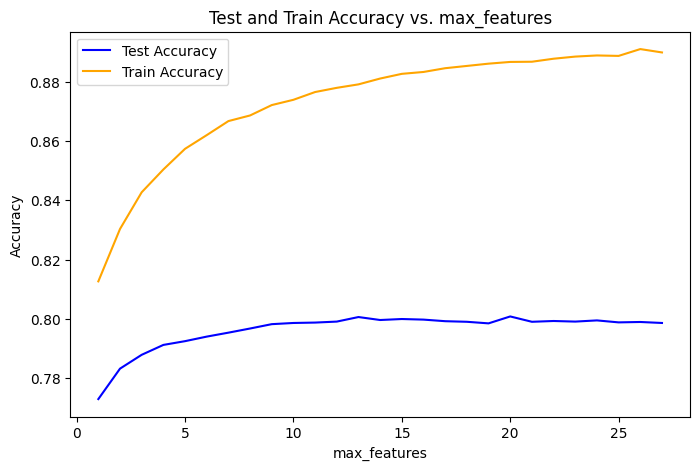

In [57]:
random_forest_param_grid = {
    "max_depth": [None],
    "max_features": range(1, 28), # 27 features
    "min_samples_leaf": [11],
    "n_estimators": [500]
}

random_forest, results = model_trainer(
    random_forest,
    prepared_X_train,
    y_train,
    random_forest_param_grid 
)

plot_accuracy_vs_hyperparameter(results, param_name="max_features")

The test accuracy marginally improves as `max_features` is increased, up to **~0.80** at **9** features before levelling out.

Meanwhile, training accuracy continues to sharply rise with `max_features`, gradually slowing.

This is a clear indication of overfitting, as there remains a large gap between the two accuracies.

#### Tuning Decision Threshold

In [59]:
best_random_forest = RandomForestClassifier(
    class_weight="balanced",
    max_depth=None,
    max_features="log2",
    min_samples_leaf=11,
    n_estimators=500
)

best_random_forest, results = model_threshold_tuner(
    best_random_forest, 
    prepared_X_train, 
    y_train
)

Best threshold: 0.481
Best F1 score: 0.545


The optimal threshold was found to be very close to the default, at **0.481**. As a result, there also appeared to be no change in F1 score from its best-found value of **0.545**.

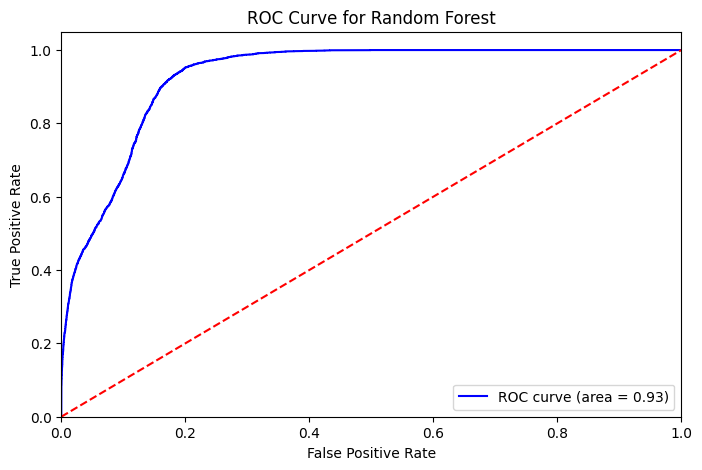

In [60]:
plot_roc_curve(
    model=best_random_forest,
    X=prepared_X_train,
    y=y_train,
    model_name="Random Forest",
)

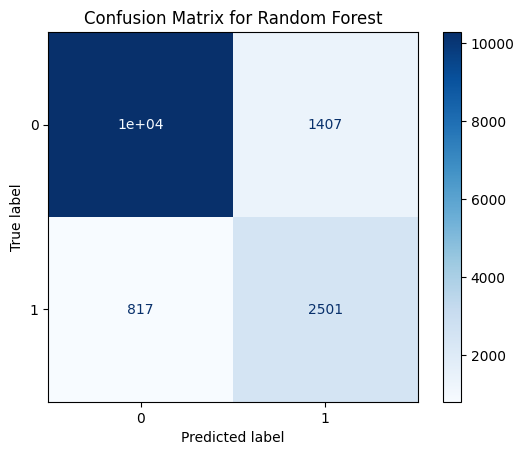

In [61]:
plot_confusion_matrix(
    model=best_random_forest,
    X=prepared_X_train,
    y=y_train,
    model_name="Random Forest"
)

#### Final Results

- F1 Score: 0.545

- Best Decision Threshold: 0.481

- AUC Score: 0.93

### 4. Bagging Classifier

Bagging is a method that builds many versions of the same model using different random samples of the training data. Each model learns slightly different patterns, with the final prediction being based on the combined output of all models.

#### Hyperparameters Tuned

1) `n_estimators`  

    The number of base models (trees) used in the ensemble:

    - More models tend to improve results but increase training time.

2) `max_samples`  

    The fraction of the traning set used to train each base mode:

    - Lower values add more randomness and help reduce overfitting.

3) `max_features`  

    The fraction of input features used for each base model:

    - Encourages diversity among trees, improving generalisation.

4) `estimator__max_depth`  

    Controls how deep each individual tree can grow:

    - `None` allows full growth, which may lead to overfitting.

    - A smaller value keeps trees simpler.

5) `estimator__min_samples_leaf`  

    The minimum number of samples required at a leaf node:
    
    - Helps prevent small, overly specific branches.

#### Initial Grid Search


In [ ]:
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(class_weight="balanced")
)

bagging_param_grid = {
    "n_estimators": [500],                                              # Number of trees
    "max_samples": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  # Proportion of samples to include per bootstrap dataset
    "max_features": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # Proportion of features to include per bootstrap dataset
    "estimator__max_depth": [None, 4],                                  # Max depth of the decision trees
    "estimator__min_samples_leaf": [11]                                 # Min. samples needed at a leaf node for the decision trees
}

bagging, results = model_trainer(
    bagging,
    prepared_X_train,
    y_train,
    bagging_param_grid,
    random=True
)

bagging

Search Parameters:
n_estimators: [500]
max_samples: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
max_features: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
estimator__max_depth: [None, 4]
estimator__min_samples_leaf: [11]

Validation Folds:
5

Performing hyperparameter search...

1: {'n_estimators': 500, 'max_samples': 0.4, 'max_features': 0.3, 'estimator__min_samples_leaf': 11, 'estimator__max_depth': 4}
    Mean F1 Score: 0.535
    Mean Precision: 0.483
    Mean Recall: 0.602
    Mean Accuracy: 0.769

2: {'n_estimators': 500, 'max_samples': 0.3, 'max_features': 1.0, 'estimator__min_samples_leaf': 11, 'estimator__max_depth': 4}
    Mean F1 Score: 0.534
    Mean Precision: 0.521
    Mean Recall: 0.547
    Mean Accuracy: 0.788

3: {'n_estimators': 500, 'max_samples': 0.8, 'max_features': 0.5, 'estimator__min_samples_leaf': 11, 'estimator__max_depth': 4}
    Mean F1 Score: 0.539
    Mean Precision: 0.503
    Mean Recall: 0.583
    Mean Accuracy: 0.779

4: {'n_estimators': 500

BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                   max_depth=4,
                                                   min_samples_leaf=11),
                  max_features=0.5, max_samples=0.1, n_estimators=500)

##### Best Model Setup
``` python
{'n_estimators': 500, 'max_samples': 0.1, 'max_features': 0.5, 'estimator__min_samples_leaf': 11, 'estimator__max_depth': None}
    Mean F1 Score: 0.544
    Mean Precision: 0.556
    Mean Recall: 0.533
    Mean Accuracy: 0.802
```

#### Accuracy vs. max_features

Search Parameters:
n_estimators: [500]
max_samples: [0.1]
max_features: range(1, 28)
estimator__min_samples_leaf: [11]
estimator__max_depth: [None]

Validation Folds:
5

Performing hyperparameter search...

1: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 11, 'max_features': 1, 'max_samples': 0.1, 'n_estimators': 500}
    Mean F1 Score: 0.464
    Mean Precision: 0.496
    Mean Recall: 0.438
    Mean Accuracy: 0.776

2: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 11, 'max_features': 2, 'max_samples': 0.1, 'n_estimators': 500}
    Mean F1 Score: 0.488
    Mean Precision: 0.523
    Mean Recall: 0.459
    Mean Accuracy: 0.787

3: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 11, 'max_features': 3, 'max_samples': 0.1, 'n_estimators': 500}
    Mean F1 Score: 0.493
    Mean Precision: 0.533
    Mean Recall: 0.46
    Mean Accuracy: 0.79

4: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 11, 'max_features': 4, 'max_samples': 0.1, 

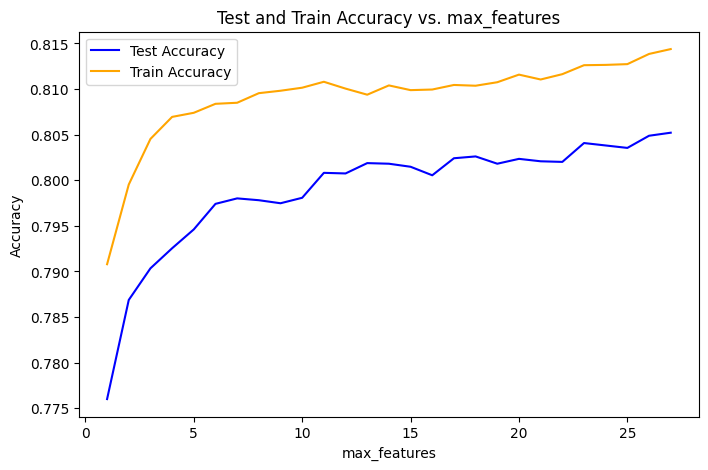

In [154]:
bagging_param_grid = {
    "n_estimators": [500],
    "max_samples": [0.1],
    "max_features": range(1, 28), # 27 features
    "estimator__min_samples_leaf": [11],
    "estimator__max_depth": [None]
}

bagging, results = model_trainer(
    bagging,
    prepared_X_train,
    y_train,
    bagging_param_grid
)

plot_accuracy_vs_hyperparameter(results, param_name="max_features")

Tuning the `max_features` parameter in the Bagging Classifier showed that using **14** features gave the best results. This setup achieved an F1 score of **0.542**, with precision of **0.554** and recall of **0.531**. Using fewer features per tree helped improve performance by reducing overfitting.

#### Tuning Decision Threshold

In [155]:
best_bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(
        class_weight="balanced",
        max_depth=None,
        min_samples_leaf=11
    ),
    n_estimators=500,
    max_samples=0.1,
    max_features=0.5,
)

best_bagging, results = model_threshold_tuner(
    best_bagging,
    prepared_X_train,
    y_train
)

Best threshold: 0.455
Best F1 score: 0.546


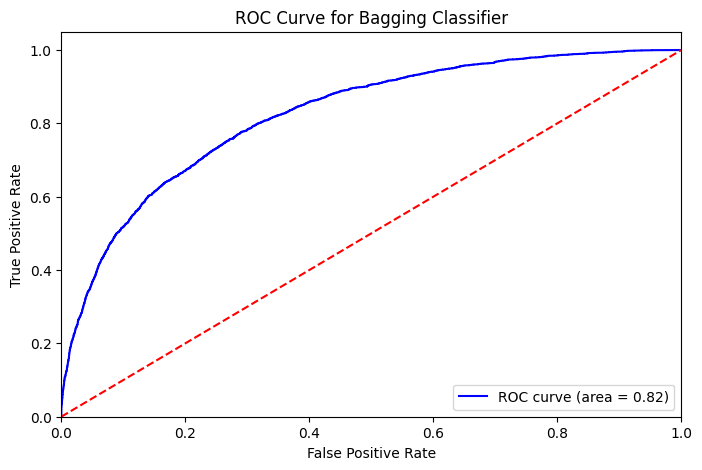

In [156]:
plot_roc_curve(
    model=best_bagging,
    X=prepared_X_train,
    y=y_train,
    model_name="Bagging Classifier",
)

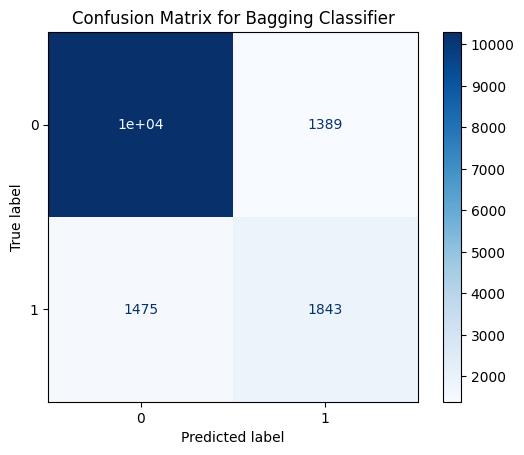

In [157]:
plot_confusion_matrix(
    model=best_bagging,
    X=prepared_X_train,
    y=y_train,
    model_name="Bagging Classifier"
)

#### Final Results

- F1 Score: 0.455

- Best Decision Threshold: 0.546

- AUC Score: 0.82

### 5. AdaBoost Classifier

AdaBoost builds sequential classifiers, each correcting the errors of the previous one, creating a stronger overall prediction.

#### Hyperparameters Tuned

1) `n_estimators`  

    The number of weak classifiers to use (model who predicts at )

2) `learning_rate`  

    A weight representing much the new model will contribute at each boosting iteration.

    - Has a trade-off with `n_estimators`, meaning for smaller alphas (learning rate), more iterations should be used.

3) `estimator__max_depth`  

    Controls how deep each individual tree can grow:

    - `None` allows full growth, which may lead to overfitting.

    - A smaller value keeps trees simpler.

4) `estimator__min_samples_leaf`  

    The minimum number of samples required at a leaf node:
    
    - Helps prevent small, overly specific branches.

#### Initial Grid Search

In [ ]:
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(class_weight="balanced")
)

ada_param_grid = {
    "n_estimators": [50, 100, 200, 300, 400, 500],              # Number of weak learners to combine
    "learning_rate": [1e-5, 1e-4, 0.001, 0.01, 0.1, 0.5, 1.0],  # Weight applied to each classifier at each boosting iteration
    "estimator__max_depth": [None, 4],                          # Max depth of the decision trees
    "estimator__min_samples_leaf": [11]                         # Min. samples needed at a leaf node for the decision trees
}

ada, results = model_trainer(
    ada,
    prepared_X_train,
    y_train,
    ada_param_grid
)

ada

Search Parameters:
n_estimators: [50, 100, 200, 300, 400, 500]
learning_rate: [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]
estimator__max_depth: [None, 4]
estimator__min_samples_leaf: [11]

Validation Folds:
5

Performing hyperparameter search...

1: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 11, 'learning_rate': 1e-05, 'n_estimators': 50}
    Mean F1 Score: 0.459
    Mean Precision: 0.366
    Mean Recall: 0.615
    Mean Accuracy: 0.679

2: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 11, 'learning_rate': 1e-05, 'n_estimators': 100}
    Mean F1 Score: 0.459
    Mean Precision: 0.367
    Mean Recall: 0.613
    Mean Accuracy: 0.68

3: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 11, 'learning_rate': 1e-05, 'n_estimators': 200}
    Mean F1 Score: 0.459
    Mean Precision: 0.367
    Mean Recall: 0.614
    Mean Accuracy: 0.68

4: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 11, 'learning_rate': 1e-05, 'n_estimators': 300}


AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    max_depth=4,
                                                    min_samples_leaf=11),
                   learning_rate=0.01, n_estimators=200)

##### Best Model Setup

``` python
{'estimator__max_depth': 4, 'estimator__min_samples_leaf': 11, 'learning_rate': 0.01, 'n_estimators': 200}
    Mean F1 Score: 0.537
    Mean Precision: 0.516
    Mean Recall: 0.562
    Mean Accuracy: 0.786
```

#### Accuracy vs. learning_rate

Search Parameters:
n_estimators: [200]
learning_rate: [0.001      0.0011514  0.00132571 0.00152642 0.00175751 0.00202359
 0.00232995 0.0026827  0.00308884 0.00355648 0.00409492 0.00471487
 0.00542868 0.00625055 0.00719686 0.00828643 0.00954095 0.01098541
 0.01264855 0.01456348 0.01676833 0.01930698 0.02222996 0.02559548
 0.02947052 0.03393222 0.0390694  0.04498433 0.05179475 0.05963623
 0.06866488 0.07906043 0.09102982 0.10481131 0.12067926 0.13894955
 0.15998587 0.184207   0.21209509 0.24420531 0.28117687 0.32374575
 0.37275937 0.42919343 0.49417134 0.5689866  0.65512856 0.75431201
 0.86851137 1.        ]
estimator__min_samples_leaf: [11]
estimator__max_depth: [4]

Validation Folds:
5

Performing hyperparameter search...

1: {'estimator__max_depth': 4, 'estimator__min_samples_leaf': 11, 'learning_rate': np.float64(0.001), 'n_estimators': 200}
    Mean F1 Score: 0.521
    Mean Precision: 0.499
    Mean Recall: 0.545
    Mean Accuracy: 0.779

2: {'estimator__max_depth': 4, 'estimator__m

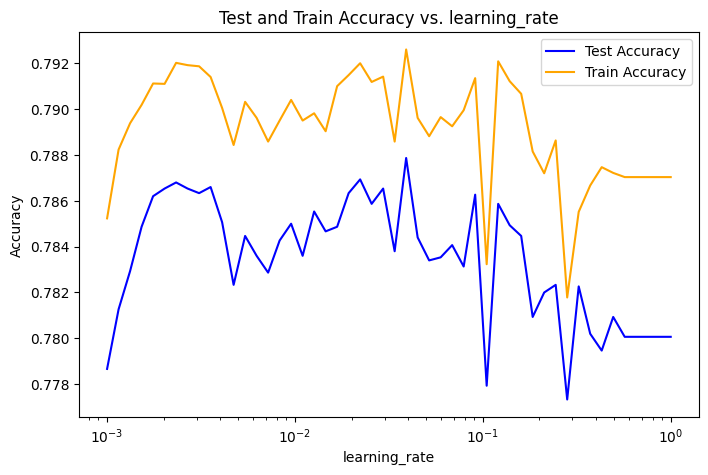

In [61]:
ada_param_grid = {
    "n_estimators": [200],
    "learning_rate": np.logspace(-3, 0),
    "estimator__min_samples_leaf": [11],
    "estimator__max_depth": [4]
}

ada, results = model_trainer(
    ada,
    prepared_X_train,
    y_train,
    ada_param_grid
)

plot_accuracy_vs_hyperparameter(results, param_name="learning_rate", log=True)

A constant large gap between the test and training accuracies indicates the model immediately begins overfitting on the training data.

From this test, it was shown a very minor improvement in F1 score (**0.537** → **0.539**) could be gained by raising the learning rate from **0.01** to **~0.07**:

``` python
{'estimator__max_depth': 4, 'estimator__min_samples_leaf': 11, 'learning_rate': np.float64(0.06866488450042997), 'n_estimators': 200}
    Mean F1 Score: 0.539
    Mean Precision: 0.512
    Mean Recall: 0.57
    Mean Accuracy: 0.784
```

#### Tuning Decision Threshold

In [34]:
best_ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        class_weight="balanced",
        max_depth=4,
        min_samples_leaf=11
    ),
    n_estimators=200,
    learning_rate=0.07,
)

best_ada, results = model_threshold_tuner(
    best_ada,
    prepared_X_train,
    y_train
)

Best threshold: 0.527
Best F1 score: 0.542


Slightly adjusting the decision threshold to **0.527** made a further small improvement from **0.539** → **0.542**.

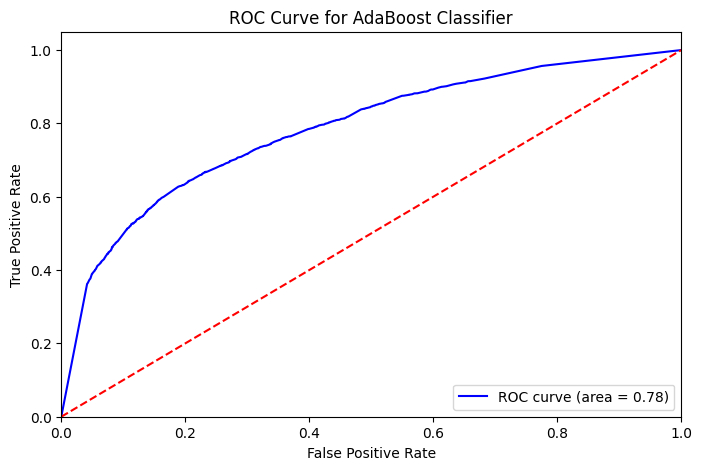

In [35]:
plot_roc_curve(
    model=best_ada,
    X=prepared_X_train,
    y=y_train,
    model_name="AdaBoost Classifier",
)

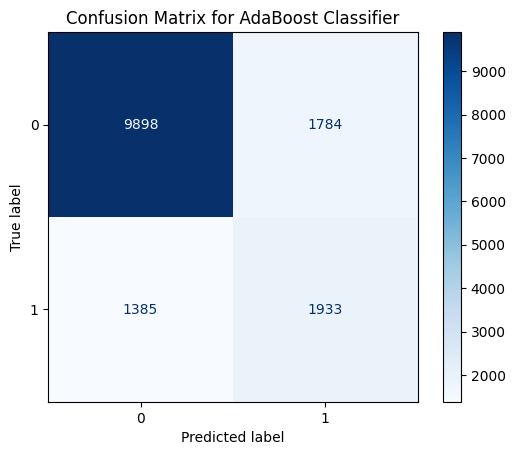

In [36]:
plot_confusion_matrix(
    model=best_ada,
    X=prepared_X_train,
    y=y_train,
    model_name="AdaBoost Classifier"
)

#### Final Results

- F1 Score: 0.542

- Best Decision Threshold: 0.527

- AUC Score: 0.78

### 6. Support Vector Classifier

A SVM (Support Vector Machine) finds the best decision boundary that seperates the classes in the data. The goal is to maximise the margin between the boundary and the closest data points from each class.

#### Hyperparameters Tuned

1) `tol`  

    This sets the stopping criteria for the optimisation process.

    - Lower values make the model train longer but produce more precise results.

    - Higher values stop training sooner, reducing runtime.

2) `C`  

    Controls the regularisation strength

    - Smaller values apply stronger regularisation, helping avoid overfitting.

    - Larger values allow the model to fit the data more closely.

We fix the kernel to `rbf` because it can handle non-linear relationships effectively.

#### Initial Grid Search

In [179]:
from sklearn.svm import SVC

svc = SVC(class_weight="balanced")

svc_param_grid = {
    "kernel": ["rbf"],
    "tol": [1e-6, 1e-5, 1e-4, 1e-3],
    "C": [1e-4, 1e-3, 0.01, 0.1, 1, 10, 100, 1_000, 10_000]
}

svc, results = model_trainer(
    svc,
    prepared_X_train,
    y_train,
    svc_param_grid
)

svc

Search Parameters:
kernel: ['rbf']
tol: [1e-06, 1e-05, 0.0001, 0.001]
C: [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

Validation Folds:
5

Performing hyperparameter search...

1: {'C': 0.0001, 'kernel': 'rbf', 'tol': 1e-06}
    Mean F1 Score: 0.362
    Mean Precision: 0.221
    Mean Recall: 1.0
    Mean Accuracy: 0.221

2: {'C': 0.0001, 'kernel': 'rbf', 'tol': 1e-05}
    Mean F1 Score: 0.362
    Mean Precision: 0.221
    Mean Recall: 1.0
    Mean Accuracy: 0.221

3: {'C': 0.0001, 'kernel': 'rbf', 'tol': 0.0001}
    Mean F1 Score: 0.362
    Mean Precision: 0.221
    Mean Recall: 1.0
    Mean Accuracy: 0.221

4: {'C': 0.0001, 'kernel': 'rbf', 'tol': 0.001}
    Mean F1 Score: 0.362
    Mean Precision: 0.221
    Mean Recall: 1.0
    Mean Accuracy: 0.221

5: {'C': 0.001, 'kernel': 'rbf', 'tol': 1e-06}
    Mean F1 Score: 0.464
    Mean Precision: 0.381
    Mean Recall: 0.596
    Mean Accuracy: 0.696

6: {'C': 0.001, 'kernel': 'rbf', 'tol': 1e-05}
    Mean F1 Score: 0.464
    Mean Pre

SVC(C=1, class_weight='balanced', tol=1e-06)

##### Best Model Setup

``` python
{'C': 1, 'kernel': 'rbf', 'tol': 1e-06}
    Mean F1 Score: 0.532
    Mean Precision: 0.496
    Mean Recall: 0.574
    Mean Accuracy: 0.777
```

#### Accuracy vs. Regularisation C

Search Parameters:
kernel: ['rbf']
tol: [1e-06]
C: [1.00000000e-04 1.61559810e-04 2.61015722e-04 4.21696503e-04
 6.81292069e-04 1.10069417e-03 1.77827941e-03 2.87298483e-03
 4.64158883e-03 7.49894209e-03 1.21152766e-02 1.95734178e-02
 3.16227766e-02 5.10896977e-02 8.25404185e-02 1.33352143e-01
 2.15443469e-01 3.48070059e-01 5.62341325e-01 9.08517576e-01
 1.46779927e+00 2.37137371e+00 3.83118685e+00 6.18965819e+00
 1.00000000e+01]

Validation Folds:
5

Performing hyperparameter search...

1: {'C': np.float64(0.0001), 'kernel': 'rbf', 'tol': 1e-06}
    Mean F1 Score: 0.362
    Mean Precision: 0.221
    Mean Recall: 1.0
    Mean Accuracy: 0.221

2: {'C': np.float64(0.00016155980984398745), 'kernel': 'rbf', 'tol': 1e-06}
    Mean F1 Score: 0.362
    Mean Precision: 0.221
    Mean Recall: 1.0
    Mean Accuracy: 0.221

3: {'C': np.float64(0.0002610157215682536), 'kernel': 'rbf', 'tol': 1e-06}
    Mean F1 Score: 0.362
    Mean Precision: 0.221
    Mean Recall: 1.0
    Mean Accuracy: 0.221

4:

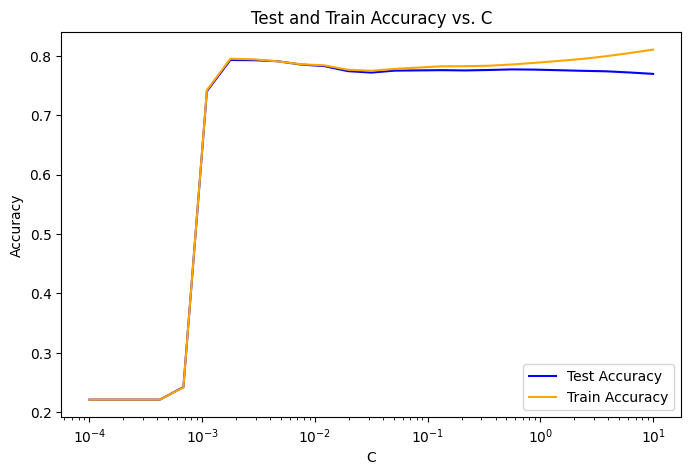

In [181]:
svc_param_grid = {
    "kernel": ["rbf"],
    "tol": [1e-6],
    "C": np.logspace(-4, 1, num=25)
}

svc, results = model_trainer(
    svc,
    prepared_X_train,
    y_train,
    svc_param_grid
)

plot_accuracy_vs_hyperparameter(results, param_name="C", log=True)

From this test, a new optimal regularisation C **~0.562** was found, increasing the best-found F1 score by a negligible amount (**0.532** → **0.533**)

At C values above **~0.6**, the test and train accuracies begin to diverge, indicating the model beginning to overfit.

#### Decision Threshold Tuning

In [184]:
best_svc = SVC(
    class_weight="balanced",
    kernel="rbf",
    tol=1e-6,
    C=0.562
)

best_svc, results = model_threshold_tuner(
    best_svc,
    prepared_X_train,
    y_train
)

Best threshold: 0.313
Best F1 score: 0.536


##### Limitations
The LinearSVC estimator **does not return predicted class probabilities**, as the model works by attempting to create an optimal hyperplane to separate class instances by, returning distances from this boundary. 

This means an ROC curve and confusion matrix can not be plotted using our `plot_roc_curve` or `plot_confusion_matrix` functions.

#### Final Results

- F1 Score: 0.536

- Best Decision Threshold: 0.313

- AUC Score: N/A

## Conclusion

### Model Comparison

| Model | Best F1 Score (After Threshold Tuning) | AUC Score |
| --- | --- | --- |
| KNeighborClassifier | 0.489 | N/A |
| DecisionTreeClassifier | 0.520 | 0.76 |
| **RandomForestClassifier** | 0.545 | **0.93** |
| BaggingClassifier | **0.546** | 0.82 |
| AdaBoostClassifier | 0.542 | 0.78 |
| SVC | 0.536 | N/A |

The model with best overall performance was the **Random Forest Classifier**, as it had by far the largest AUC score (**0.93**) and the difference between its best F1 score and the largest found is negligible (**0.545** vs. **0.546**).

### Performance on Test Set

In [161]:
prepared_X_test = preprocess_data(X_test) # Prepare the test set

prepared_X_test.shape

(15000, 27)

In [162]:
best_random_forest = RandomForestClassifier(
    class_weight="balanced",
    max_depth=None,
    max_features="log2",
    min_samples_leaf=11,
    n_estimators=500
).fit(prepared_X_train, y_train)

best_random_forest # Best model setup trained on entire training set

RandomForestClassifier(class_weight='balanced', max_features='log2',
                       min_samples_leaf=11, n_estimators=500)

As no real costs for the predictions are known, a manual decision threshold was selected to achieve an arbitrarily-decided recall of **~80%**.

From the best Random Forest setup, two final models have been derived by tuning their decision thresholds to optimise separate metrics (recall and F1).

In [170]:
from sklearn.model_selection import FixedThresholdClassifier

optimal_recall_model = FixedThresholdClassifier(
    estimator=best_random_forest,
    threshold=0.28 # Manual threshold selected to prioritise recall
).fit(prepared_X_train, y_train)

optimal_f1_model, results = model_threshold_tuner(
    best_random_forest,
    prepared_X_train,
    y_train
)

Best threshold: 0.475
Best F1 score: 0.545


In [164]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def print_test_scores(y_preds: np.ndarray) -> None:
    """Print all binary classification metric performances on the test set."""
    recall = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    accuracy = accuracy_score(y_test, y_preds)

    # Print the results on the test set
    print(f"    Recall: {GREEN}{recall:.3f}{RESET}")
    print(f"    F1 Score: {GREEN}{f1:.3f}{RESET}")
    print(f"    Precision: {GREEN}{precision:.3f}{RESET}")
    print(f"    Accuracy: {GREEN}{accuracy:.3f}{RESET}")


The code below displays the results on the test set of both final classifiers:

- One whose decision threshold was tuned to maximise F1 (`optimal_f1_model`).

- The other, tuned to achieve an arbitrary recall of **~80%** (`optimal_recall_model`).

Recall-Optimised Random Forest Performance on Test Set:
    Recall: 0.802
    F1 Score: 0.476
    Precision: 0.339
    Accuracy: 0.610


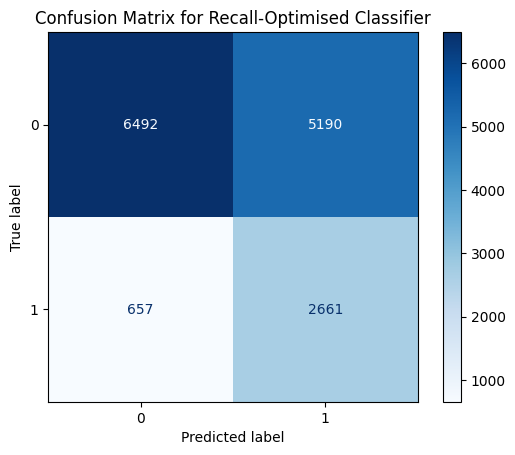


F1-Optimised Random Forest Performance on Test Set:
    Recall: 0.487
    F1 Score: 0.530
    Precision: 0.580
    Accuracy: 0.809


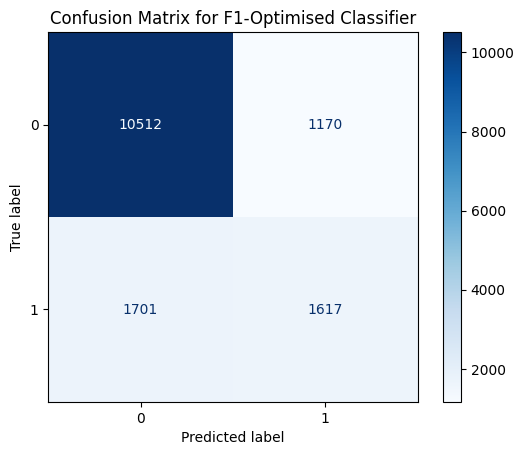

In [171]:
y_preds_1 = optimal_recall_model.predict(prepared_X_test)

print(f"{UNDERLINE}{BLUE}Recall-Optimised Random Forest Performance on Test Set:{RESET}")
print_test_scores(y_preds_1)

plot_confusion_matrix(
    model=optimal_recall_model,
    X=prepared_X_test,
    y=y_test,
    model_name="Recall-Optimised Classifier"
)

y_preds_2 = optimal_f1_model.predict(prepared_X_test)

print(f"\n{UNDERLINE}{BLUE}F1-Optimised Random Forest Performance on Test Set:{RESET}")
print_test_scores(y_preds_2)

plot_confusion_matrix(
    model=optimal_f1_model,
    X=prepared_X_test,
    y=y_test,
    model_name="F1-Optimised Classifier"
)

### Final Model Selection

In conclusion, selection of either classifier is context-dependent, as one may fit the needs of the application better than the other depending on the costs of the true positives, false positives, true negatives, and false negatives (as might be described in a cost matrix).

For instance, if the cost of a **false negative** (incorrectly predicting a borrower as a non-defaulter) is significantly higher than the cost of a **false positive** (incorrectly predicting a borrower as a defaulter), the model with a higher recall (`optimal_recall_model`) would be preferred as it minimises the number of false negatives.

On the other hand, if the risk associated with a **false negative** was lower or similar to that of a **false positive**, the model with the highest F1 (`optimal_f1_model`) should be chosen as it strikes the best balance between precision and recall.